In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Model

In [ ]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")


In [ ]:
data.head(50)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [ ]:
data = data.fillna(method="ffill")

In [ ]:
data.head(50)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 18794
Unique tags in corpus: 17


In [ ]:

words=list(data['Word'].unique())
words.append("ENDPAD")
tags=list(data['Tag'].unique())

In [ ]:

print("Unique tags are:", tags)

Unique tags are: ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


In [ ]:

num_words = len(words)
num_tags = len(tags)

In [ ]:

num_words

18795

In [ ]:

class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [ ]:

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}


In [ ]:

X1 = [[word2idx[w[0]] for w in s] for s in sentences]

In [ ]:

max_len = 50


In [ ]:

X = sequence.pad_sequences(maxlen=max_len,
                  sequences=X1, padding="post",
                  value=num_words-1)

In [ ]:

y1 = [[tag2idx[w[2]] for w in s] for s in sentences]

In [ ]:


y = sequence.pad_sequences(maxlen=max_len,
                  sequences=y1,
                  padding="post",
                  value=tag2idx["O"])


In [ ]:


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=1)

In [ ]:
input_word = layers.Input(shape=(max_len,))
embedding_layer=layers.Embedding(input_dim=num_words,output_dim=50,input_length=max_len)(input_word)
dropout_layer=layers.SpatialDropout1D(0.1)(embedding_layer)
bidirectional_lstm=layers.Bidirectional(
    layers.LSTM(units=100,return_sequences=True,
                recurrent_dropout=0.1))(dropout_layer)
output=layers.TimeDistributed(
    layers.Dense(num_tags,activation="softmax"))(bidirectional_lstm)
model = Model(input_word, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            939750    
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 50)            0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 50, 200)           120800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 17)            3417      
 ributed)                                                        
                                                             

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test,y_test),
    batch_size=32,
    epochs=3,
)

Epoch 1/3
331/331 [==============================] - 77s 197ms/step - loss: 0.3600 - accuracy: 0.9335 - val_loss: 0.1753 - val_accuracy: 0.9480
Epoch 2/3
331/331 [==============================] - 65s 196ms/step - loss: 0.1441 - accuracy: 0.9556 - val_loss: 0.1201 - val_accuracy: 0.9684
Epoch 3/3
331/331 [==============================] - 65s 196ms/step - loss: 0.0851 - accuracy: 0.9768 - val_loss: 0.0807 - val_accuracy: 0.9787


In [ ]:

metrics = pd.DataFrame(model.history.history)
metrics.head()


,loss,accuracy,val_loss,val_accuracy
0,0.360012,0.933540,0.175280,0.947961
1,0.144129,0.955588,0.120141,0.968437
2,0.085069,0.976771,0.080674,0.978683


<Axes: >

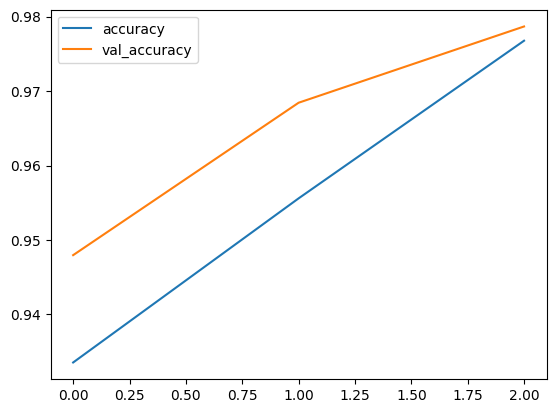

In [ ]:


metrics[['accuracy','val_accuracy']].plot()

<Axes: >

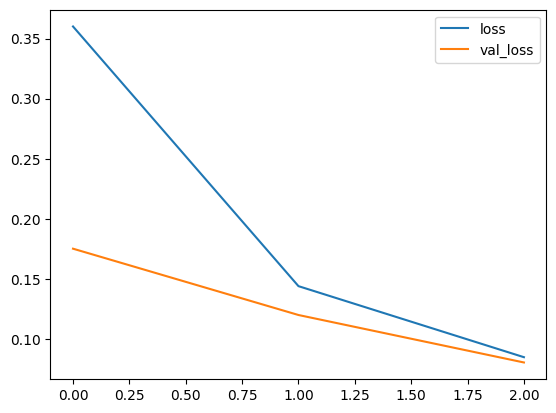

In [ ]:


metrics[['loss','val_loss']].plot()

In [ ]:

i = 50
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 1s 778ms/step
Word           True 	 Pred

------------------------------
Executive      O	O
Director       O	O
James          B-per	B-per
Morris         I-per	I-per
says           O	O
if             O	O
donors         O	O
had            O	O
responded      O	O
earlier        O	O
,              O	O
the            O	O
cost           O	O
of             O	O
the            O	O
operation      O	O
would          O	O
be             O	O
greatly        O	O
reduced        O	O
.              O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	